<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/simulation/eventsimulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import scipy.integrate as integrate # for numerical solution od differential equations
import matplotlib.pyplot as plt     # for plots
import pandas as pd                 # for tables
import numpy as np                  # for matrices

plt.rcParams["figure.figsize"] = (15,10)

,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


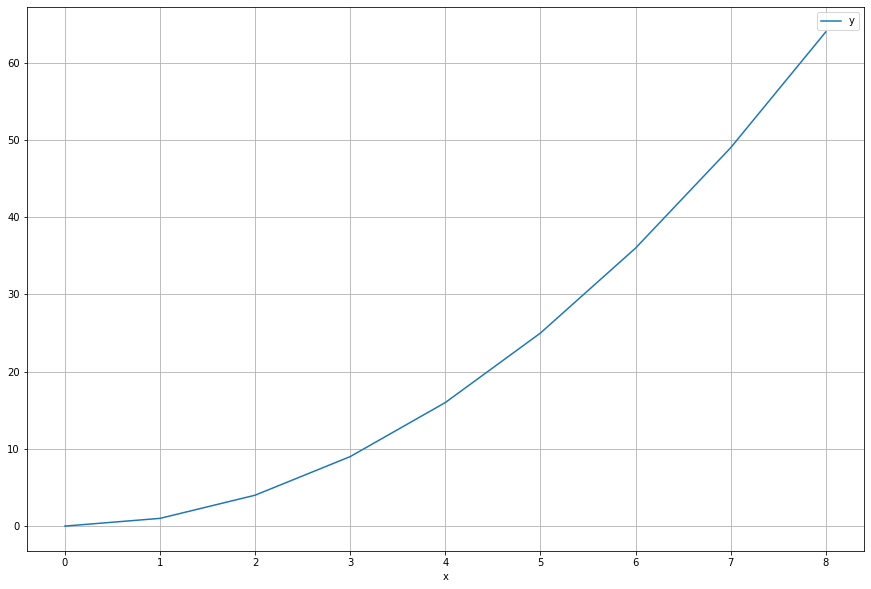

In [55]:
def displayData(data):
  display(pd.DataFrame(data))

def plotData(data, x = 0, y = 1, ax = None):
  df = pd.DataFrame(data)
  newax = None
  if ax is None:
    newax = df.plot.line(x = x, y = y)
  else:
    newax = df.plot.line(x = x, y = y, ax = ax)
  return newax

#=================#
# example of use  #
#=================#
#data = [(0, 0), (1, 1), (2, 4), (3, 9), (4, 16), (5, 25), (6, 36), (7, 49)]
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
plotData(data)
plt.grid(which='both')
displayData(data)

## Událostní kalendář
Třída pro událostní simulaci. Událostní simulace umožňuje spouštění událostí - akcí v časové souslednosti bez ohledu na souslednost plánování.

In [56]:
class EventCalendar:
  
  def __init__(self):
    self._queue = []
    self.onStep = []
    self.time = 0
    pass

  #Metoda pro vykonání jednoho kroku simulace
  def Step(self):
    #setřídit frontu / list událostí podle položky time / čas
    #self._queue.sort(key = lambda item: item['time'])
    #neni treba tridit, vkladani zarucuje spravne poradi
    
    #z fronty odstraň nejstarší událost
    currentEvent = self._queue.pop(0)

    #vyvolej funkci, která je spojena s danou událostí
    func = currentEvent['executor']
    time = currentEvent['time']
    result = func(time, **currentEvent['kwargs'])
    
    self.time = time

    #vrať událost, která byla zpracována
    extendedResult = {**currentEvent, 'result': result}

    for f in self.onStep:
      f(extendedResult)

    return extendedResult

  #Metoda pro získání informace o času nejstarší události, 
  #tj. události, která bude zpracována jako první
  def PrepareNext(self):
    #setřídit frontu / list událostí podle položky time / čas
    #self._queue.sort(key = lambda item: item['time'])
    #neni treba tridit, vkladani zarucuje spravne poradi

    #vrať čas nejstarší události
    return self._queue[0]['time']

  #Vložení události do fronty událostí, 
  #futureTime - čas, kdy bude událost vyvolána
  #f - funkce, která bude v čase události vykonána / volána
  #kwargs - volitelné argumenty funkce
  def AddEvent(self, futureTime, f, **kwargs):
    if not callable(f):
      raise ValueError(f, 'must be callable')

    if futureTime < self.time:
      raise ValueError('New event cannot happen in past')

    index = 0
    for index, event in enumerate(self._queue):
      if event['time'] > futureTime:
        break
      index += 1

    self._queue.insert(index, {'time': futureTime, 'executor': f, 'kwargs': kwargs})
    return self

  def AddEventGenerator(self, generator):
    def planEvent():
      print('going to planEvent')
      try:
        event = next(generator) # prvni, ziskame Tuple o trech prvcich
      except StopIteration:
        pass
      else:
        func = event[0] # co ma byt vykonano
        futureTime = event[1] # cas dalsi udalosti
        kwargs = {} if len(event) < 3 else event[2] # dodatecne parametry
        print('plan for', futureTime)
        self.AddEvent(futureTime, generatorEvent, hook = func, kwargs = kwargs)  

    def generatorEvent(time, hook, kwargs):
        print('generatorEvent')
        result = hook(time, **kwargs)
        planEvent()
        return result

    planEvent()

  def __iter__(self):
    while len(self._queue) > 0:
      yield self.Step()

  def StopSimulation(self):
    self._queue = []      

yield {'time': 9.999000075938193e-05, 'y': [10.0, 9.99901909809255, 0.0009999000075938194, 0.0009998509674025839], 'yd': [0, -9.81, 10.0, 9.99901909809255]}
yield {'time': 0.0010998900083532014, 'y': [10.0, 9.989210079018054, 0.010998900083532014, 0.01099296622039253], 'yd': [0, -9.81, 10.0, 9.989210079018054]}
yield {'time': 0.011098890084291395, 'y': [10.0, 9.891119888273101, 0.11098890084291396, 0.11038467664670285], 'yd': [0, -9.81, 10.0, 9.891119888273101]}
yield {'time': 0.0735988900842914, 'y': [10.0, 9.277994888273101, 0.7359889008429139, 0.7094195134137716], 'yd': [0, -9.81, 10.0, 9.277994888273101]}
yield {'time': 0.13609889008429138, 'y': [10.0, 8.6648698882731, 1.360988900842914, 1.2701340376808403], 'yd': [0, -9.81, 10.0, 8.6648698882731]}
yield {'time': 0.19859889008429138, 'y': [10.0, 8.0517448882731, 1.985988900842914, 1.7925282494479091], 'yd': [0, -9.81, 10.0, 8.0517448882731]}
yield {'time': 0.2610988900842914, 'y': [10.0, 7.4386198882731005, 2.610988900842914, 2.276

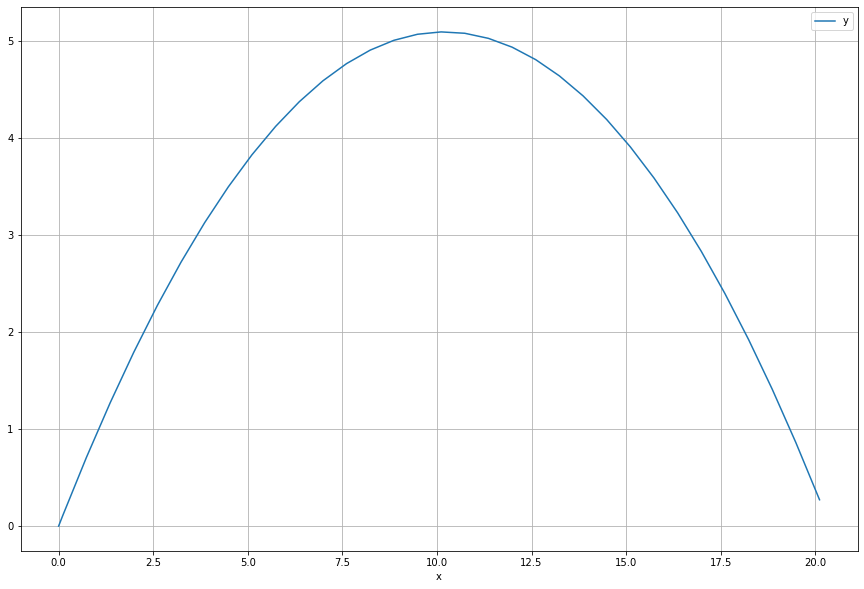

In [57]:
def compute(model, state0, t0 = 0.0, t_bound = 10, max_step = 0.0625):
  solver = integrate.RK45(fun = model, t0 = t0, y0 = state0, t_bound = t_bound, max_step = max_step)

  while True:
    message = solver.step()
    currentItem = {'time': solver.t, 'y': [*solver.y], 'yd': [*model(solver.t, solver.y)]}

    print('yield', currentItem)
    yield currentItem # send signal, inform about current result
    if (not(solver.status == 'running')):
        break
  return

#=================#
# example of use  #
#=================#
def model2D(time, state):
  velocity = state[:2]
  position = state[2:]
  acceleration = [0, -9.81]
  return [*acceleration, *velocity]

sim = compute(model2D, [10, 10, 0, 0])
result = []
for index, state in enumerate(sim):
  result.append(state)
  if index == 34: #magic number
    break

xy = list(map(lambda item: {'x': item['y'][2], 'y': item['y'][3]}, result))
plotData(xy)
plt.grid(which='both')

In [58]:
fronta = []
def doFronty(time, calendar):
  fronta.append(len(fronta))
  calendar.AddEvent(time + 1, doFronty, calendar = calendar)

def zFronty(time, calendar):
  if len(fronta) > 0:
    fronta.pop()
  calendar.AddEvent(time + 1, zFronty, calendar = calendar)

def simulateIt(calendar, bindedCompute):
  def singleStep(time, solution):
    return solution
    
  def asGenerator():
    print('asGenerator')
    solver = bindedCompute()
    for solution in solver:
      yield singleStep, solution['time'], {'solution': solution}

  calendar.AddEventGenerator(asGenerator())

def startSimulation(bindedCompute, calendar, hook):
  solver = bindedCompute()
  solution = next(solver)
  calendar.AddEvent(solution['time'], stepSimulation, solver = solver, solution = solution, hook = hook)

def stepSimulation(event, calendar, solver, solution, hook):
  hook(solution)
  solution = next(solver)
  calendar.AddEvent(solution['time'], stepSimulation, solver = solver, solution = solution, hook = hook)


In [59]:
results = []
def hook(event):
  print(event)
  if event['result'] is None:
    return
  if not 'time' in event['result']:
    return
  results.append({**event['result'], 'queueL': len(fronta)})

calendar = EventCalendar()
calendar.onStep += [hook]

bindedCompute = lambda : compute(model2D, [10, 10, 0, 0])
simulateIt(calendar, bindedCompute)

calendar.AddEvent(0, doFronty, calendar = calendar)
calendar.AddEvent(0.8, zFronty, calendar = calendar)

for index, event in enumerate(calendar):
  #print(index, event)
  if index > 20:
    break

displayData(results)
for index, event in enumerate(calendar):
  #print(index, event)
  if index > 20:
    break

displayData(results)


going to planEvent
asGenerator
yield {'time': 9.999000075938193e-05, 'y': [10.0, 9.99901909809255, 0.0009999000075938194, 0.0009998509674025839], 'yd': [0, -9.81, 10.0, 9.99901909809255]}
plan for 9.999000075938193e-05
{'time': 0, 'executor': <function doFronty at 0x7f0245178d08>, 'kwargs': {'calendar': <__main__.EventCalendar object at 0x7f02446d94a8>}, 'result': None}
generatorEvent
going to planEvent
yield {'time': 0.0010998900083532014, 'y': [10.0, 9.989210079018054, 0.010998900083532014, 0.01099296622039253], 'yd': [0, -9.81, 10.0, 9.989210079018054]}
plan for 0.0010998900083532014
{'time': 9.999000075938193e-05, 'executor': <function EventCalendar.AddEventGenerator.<locals>.generatorEvent at 0x7f024517fc80>, 'kwargs': {'hook': <function simulateIt.<locals>.singleStep at 0x7f024517fe18>, 'kwargs': {'solution': {'time': 9.999000075938193e-05, 'y': [10.0, 9.99901909809255, 0.0009999000075938194, 0.0009998509674025839], 'yd': [0, -9.81, 10.0, 9.99901909809255]}}}, 'result': {'time': 

,time,y,yd,queueL
0,0.000100,"[10.0, 9.99901909809255, 0.0009999000075938194...","[0, -9.81, 10.0, 9.99901909809255]",1
1,0.001100,"[10.0, 9.989210079018054, 0.010998900083532014...","[0, -9.81, 10.0, 9.989210079018054]",1
2,0.011099,"[10.0, 9.891119888273101, 0.11098890084291396,...","[0, -9.81, 10.0, 9.891119888273101]",1
3,0.073599,"[10.0, 9.277994888273101, 0.7359889008429139, ...","[0, -9.81, 10.0, 9.277994888273101]",1
4,0.136099,"[10.0, 8.6648698882731, 1.360988900842914, 1.2...","[0, -9.81, 10.0, 8.6648698882731]",1
5,0.198599,"[10.0, 8.0517448882731, 1.985988900842914, 1.7...","[0, -9.81, 10.0, 8.0517448882731]",1
6,0.261099,"[10.0, 7.4386198882731005, 2.610988900842914, ...","[0, -9.81, 10.0, 7.4386198882731005]",1
7,0.323599,"[10.0, 6.8254948882731, 3.235988900842914, 2.7...","[0, -9.81, 10.0, 6.8254948882731]",1
8,0.386099,"[10.0, 6.2123698882731, 3.860988900842914, 3.1...","[0, -9.81, 10.0, 6.2123698882731]",1
9,0.448599,"[10.0, 5.5992448882731, 4.485988900842914, 3.4...","[0, -9.81, 10.0, 5.5992448882731]",1


generatorEvent
going to planEvent
yield {'time': 1.1360988900842914, 'y': [10.0, -1.1451301117269002, 11.360988900842916, 5.03000392595394], 'yd': [0, -9.81, 10.0, -1.1451301117269002]}
plan for 1.1360988900842914
{'time': 1.0735988900842914, 'executor': <function EventCalendar.AddEventGenerator.<locals>.generatorEvent at 0x7f024517fc80>, 'kwargs': {'hook': <function simulateIt.<locals>.singleStep at 0x7f024517fe18>, 'kwargs': {'solution': {'time': 1.0735988900842914, 'y': [10.0, -0.5320051117269002, 10.735988900842916, 5.082414401686871], 'yd': [0, -9.81, 10.0, -0.5320051117269002]}}}, 'result': {'time': 1.0735988900842914, 'y': [10.0, -0.5320051117269002, 10.735988900842916, 5.082414401686871], 'yd': [0, -9.81, 10.0, -0.5320051117269002]}}
generatorEvent
going to planEvent
yield {'time': 1.1985988900842914, 'y': [10.0, -1.7582551117269, 11.985988900842916, 4.939273137721009], 'yd': [0, -9.81, 10.0, -1.7582551117269]}
plan for 1.1985988900842914
{'time': 1.1360988900842914, 'executor'

,time,y,yd,queueL
0,0.000100,"[10.0, 9.99901909809255, 0.0009999000075938194...","[0, -9.81, 10.0, 9.99901909809255]",1
1,0.001100,"[10.0, 9.989210079018054, 0.010998900083532014...","[0, -9.81, 10.0, 9.989210079018054]",1
2,0.011099,"[10.0, 9.891119888273101, 0.11098890084291396,...","[0, -9.81, 10.0, 9.891119888273101]",1
3,0.073599,"[10.0, 9.277994888273101, 0.7359889008429139, ...","[0, -9.81, 10.0, 9.277994888273101]",1
4,0.136099,"[10.0, 8.6648698882731, 1.360988900842914, 1.2...","[0, -9.81, 10.0, 8.6648698882731]",1
5,0.198599,"[10.0, 8.0517448882731, 1.985988900842914, 1.7...","[0, -9.81, 10.0, 8.0517448882731]",1
6,0.261099,"[10.0, 7.4386198882731005, 2.610988900842914, ...","[0, -9.81, 10.0, 7.4386198882731005]",1
7,0.323599,"[10.0, 6.8254948882731, 3.235988900842914, 2.7...","[0, -9.81, 10.0, 6.8254948882731]",1
8,0.386099,"[10.0, 6.2123698882731, 3.860988900842914, 3.1...","[0, -9.81, 10.0, 6.2123698882731]",1
9,0.448599,"[10.0, 5.5992448882731, 4.485988900842914, 3.4...","[0, -9.81, 10.0, 5.5992448882731]",1
